In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
import umap
from sklearn.manifold import TSNE

2024-11-23 14:35:23.960833: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-23 14:35:24.167272: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-23 14:35:24.242941: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-23 14:35:24.263819: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 14:35:24.407512: I tensorflow/core/platform/cpu_feature_guar

In [4]:
class DimensionalityReduction:
    
    def __init__(self, file_path): 
        self.data = np.loadtxt(file_path)  
        self.std_data = None 
        self.mean = None
        self.standard_dev= None
        self.cov_matrix = None 
        self.eigenvalues = None 
        self.eigenvectors = None 
        self.final_data = None
    
    def standardize_data(self):
        self.standard_dev = np.std(self.data, axis=0)
        self.mean = np.mean(self.data, axis=0) 
        self.std_data = (self.data - self.mean) / self.standard_dev
    
    def perform_pca(self, n=2):
        cov_matrix = np.cov(self.std_data, rowvar=False)
        self.eigenvalues, self.eigenvectors = np.linalg.eigh(cov_matrix)
        idx = np.argsort(self.eigenvalues)[::-1]
        self.eigenvectors = self.eigenvectors[:, idx]
        self.eigenvectors = self.eigenvectors[:, :n]
        self.final_data = np.dot(self.std_data, self.eigenvectors)
        return self.final_data
    
    def draw_pca(self):
        plt.scatter(self.final_data[:, 0], self.final_data[:, 1], s=15, alpha=0.7)
        plt.title('2D PCA Projection')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.show()
    
    def draw_umap(self, n=2):
        umap_data = umap.UMAP(random_state=42).fit_transform(self.data)
        plt.scatter(umap_data[:, 0], umap_data[:, 1], alpha=0.5)
        plt.xlabel('UMAP Component 1') 
        plt.ylabel('UMAP Component 2') 
        plt.title('UMAP - 2D Projection')
        plt.show() 

    def draw_tsne(self,n=2): 
        tsne_data = TSNE(random_state=42).fit_transform(self.data)
        plt.scatter(tsne_data[:, 0], tsne_data[:, 1], alpha=0.5) 
        plt.xlabel('tSNE Component 1') 
        plt.ylabel('tSNE Component 2') 
        plt.title('tSNE - 2D Projection') 

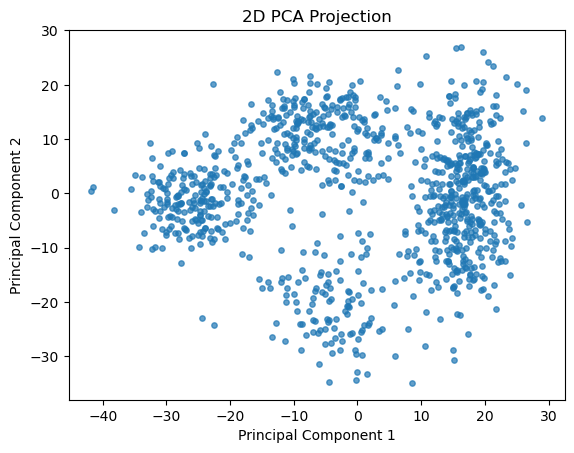

/home/udisha/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


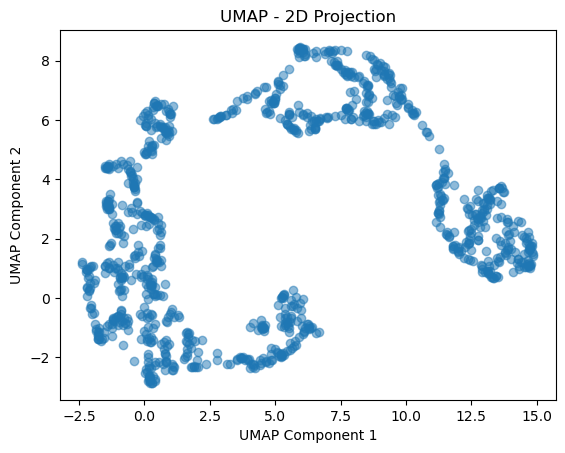

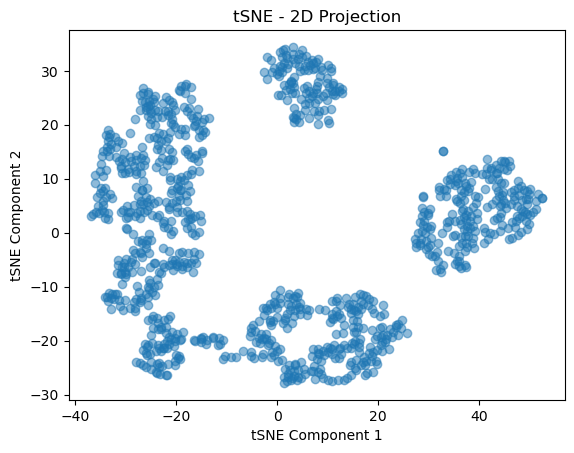

In [5]:
dr = DimensionalityReduction('pca_data.txt')
dr.standardize_data()
dr.perform_pca(n=2)
dr.draw_pca()
dr.draw_umap(n=2)
dr.draw_tsne(n=2)

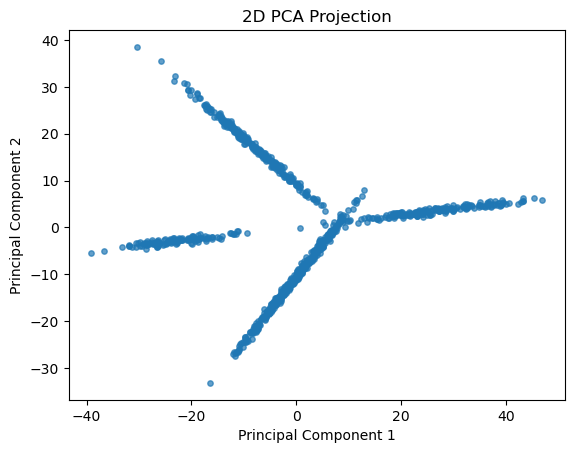

/home/udisha/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


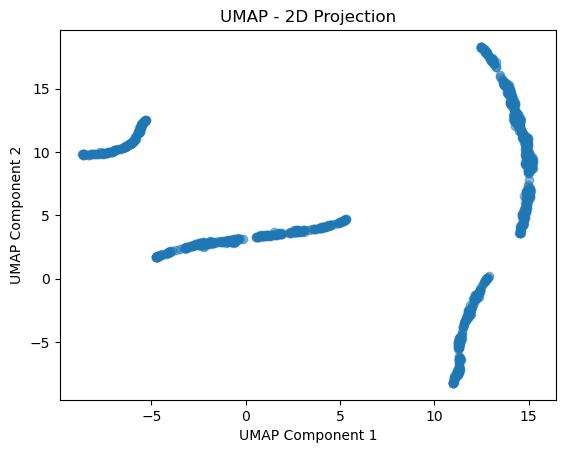

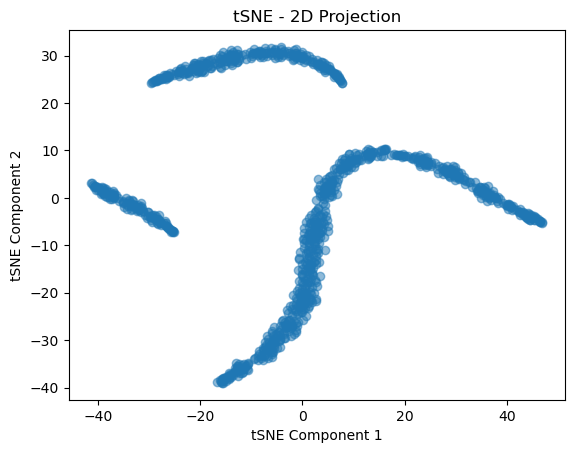

In [10]:
dr = DimensionalityReduction('pca_data_online_1.txt')
dr.standardize_data()
dr.perform_pca(n=2)
dr.draw_pca()
dr.draw_umap(n=2)
dr.draw_tsne(n=2)

In [8]:
from scipy.stats import poisson

class ExpectationMaximization:
    
    def __init__(self, file_path):
        self.data = np.loadtxt(file_path)
        self.N = len(self.data)
        np.random.seed(0)  
        self.mean_fp = np.random.rand() * np.mean(self.data)  
        self.mean_no_fp = np.random.rand() * np.mean(self.data)
        self.proportion_fp = 0.5  
        self.responsibilities_fp = np.zeros(self.N)
        self.responsibilities_no_fp = np.zeros(self.N)
    
    def e_step(self):
        p_fp = poisson.pmf(self.data, self.mean_fp)  
        p_no_fp = poisson.pmf(self.data, self.mean_no_fp)  
        responsibilities_fp = self.proportion_fp * p_fp
        responsibilities_no_fp = (1 - self.proportion_fp) * p_no_fp
        sum_responsibilities = responsibilities_fp + responsibilities_no_fp
        self.responsibilities_fp = responsibilities_fp / sum_responsibilities
        self.responsibilities_no_fp = responsibilities_no_fp / sum_responsibilities
    
    def m_step(self):
        self.mean_fp = np.sum(self.responsibilities_fp * self.data) / np.sum(self.responsibilities_fp)
        self.mean_no_fp = np.sum(self.responsibilities_no_fp * self.data) / np.sum(self.responsibilities_no_fp)
        self.proportion_fp = np.mean(self.responsibilities_fp)
    
    def fit(self, iterations=200, tol=1e-6):
        for i in range(iterations):
            old_mean_fp = self.mean_fp
            old_mean_no_fp = self.mean_no_fp
            old_proportion_fp = self.proportion_fp
            self.e_step()
            self.m_step()
            if (abs(self.mean_fp - old_mean_fp) < tol and
                abs(self.mean_no_fp - old_mean_no_fp) < tol and
                abs(self.proportion_fp - old_proportion_fp) < tol):
                print(f"Converged after {i+1} iterations.")
                break
    def compute_log_likelihood(self):
       
        p_fp = poisson.pmf(self.data, self.mean_fp)  
        p_no_fp = poisson.pmf(self.data, self.mean_no_fp)  
        
        total_prob = self.proportion_fp * p_fp + (1 - self.proportion_fp) * p_no_fp
  
        log_likelihood = np.sum(np.log(total_prob))
        
        return log_likelihood

    def fit2(self, iterations=200, tol=1e-6):
        prev_log_likelihood = None
        for i in range(iterations):
            old_mean_fp = self.mean_fp
            old_mean_no_fp = self.mean_no_fp
            old_proportion_fp = self.proportion_fp
            
            self.e_step()
            self.m_step()
            
            current_log_likelihood = self.compute_log_likelihood()
            
            if prev_log_likelihood is not None and abs(current_log_likelihood - prev_log_likelihood) < tol:
                print(f"Converged after {i+1} iterations (log-likelihood).")
                break
    
            prev_log_likelihood = current_log_likelihood
      
            if (abs(self.mean_fp - old_mean_fp) < tol and
                abs(self.mean_no_fp - old_mean_no_fp) < tol and
                abs(self.proportion_fp - old_proportion_fp) < tol):
                print(f"Converged after {i+1} iterations (parameters).")
                break

    
    def print_results(self):
        print(f"Mean number of children in families with family planning: {self.mean_fp:.9f}")
        print(f"Mean number of children in families without family planning: {self.mean_no_fp:.9f}")
        print(f"Proportion of families with family planning: {self.proportion_fp:.9f}")
        print(f"Proportion of families without family planning: {1 - self.proportion_fp:.9f}")
        
file_path = 'em_data.txt' 
em = ExpectationMaximization(file_path)
em.fit2()
em.print_results()

Converged after 115 iterations (log-likelihood).
Mean number of children in families with family planning: 1.783067342
Mean number of children in families without family planning: 4.911278062
Proportion of families with family planning: 0.356203006
Proportion of families without family planning: 0.643796994


In [ ]:
# from sklearn.mixture import GaussianMixture

# data = np.loadtxt('em_data.txt')
# data_reshaped = data.reshape(-1, 1)
# gmm = GaussianMixture(n_components=2, random_state=0)
# gmm.fit(data_reshaped)
# means = gmm.means_.flatten()

# proportions = gmm.weights_

# print(f"Mean number of children for group 1 (approximate): {means[0]:.2f}")
# print(f"Mean number of children for group 2 (approximate): {means[1]:.2f}")
# print(f"Proportion of group 1 (approximate): {proportions[0]:.2f}")
# print(f"Proportion of group 2 (approximate): {proportions[1]:.2f}")

# plt.hist(data, bins=30, density=True, alpha=0.6, color='g')
# plt.title("Histogram of Children per Family")
# plt.show()


In [9]:
file_path = 'em_data_online_1.txt' 
em = ExpectationMaximization(file_path)
em.fit2()
em.print_results()

Mean number of children in families with family planning: 10.712722749
Mean number of children in families without family planning: 15.537225089
Proportion of families with family planning: 0.490667207
Proportion of families without family planning: 0.509332793


In [11]:
file_path = 'em_data_online_1.txt' 
em = ExpectationMaximization(file_path)
em.fit()
em.print_results()

Mean number of children in families with family planning: 10.712722749
Mean number of children in families without family planning: 15.537225089
Proportion of families with family planning: 0.490667207
Proportion of families without family planning: 0.509332793
